# PointNet Implementation
## for Semantic Segmentation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
import time as t
import scipy.constants as spc

import sys
sys.path.append('/home/russbate/MLPionCollaboration/LCStudies/')
from util import resolution_util as ru
from util import plot_util as pu
from util import deep_set_util as dsu

## Declare GPUs and Import TensorFlow

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "4"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

2021-10-01 13:41:47.456327: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-01 13:41:57.160184: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-01 13:41:57.185484: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-01 13:41:57.376155: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1746] Found device 0 with properties: 
pciBusID: 0000:88:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-10-01 13:41:57.376225: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-01 13:41:57.445868: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2

['/device:GPU:0']

## Load Models for PointNet

## Load Data
### X = [Energy, Eta, Phi, rPerp]
### Y = [EM Energy, non EM Energy]

In [3]:
t0 = t.time()
Xraw = np.load('/data/atlas/rbate/Rho_X_4_files.npy', mmap_mode='r')[:,:,:]
Yraw = np.load('/data/atlas/rbate/Rho_Y_4_files.npy', mmap_mode='r')[:,:,:]
print(Xraw.shape)
print(Yraw.shape)

X = np.lib.format.open_memmap('/data/atlas/rbate/XR_notebook.npy',
                             mode='w+', dtype=np.float64, shape=(Xraw.shape[0], Xraw.shape[1], Xraw.shape[2]))
np.copyto(dst=X, src=Xraw[:,:,:], casting='same_kind', where=True)

Y = np.lib.format.open_memmap('/data/atlas/rbate/YR_notebook.npy',
                             mode='w+', dtype=np.float64, shape=(Yraw.shape[0], Yraw.shape[1], Yraw.shape[2]))
np.copyto(dst=Y, src=Yraw[:,:,:], casting='same_kind', where=True)
t1 = t.time()
print('Time to load memory mapped data: '+str(t1-t0)+' (s)')

(2550, 1078, 4)
(2550, 1078, 2)
Time to load memory mapped data: 0.4353768825531006 (s)


## Show Inputs

In [22]:
E_mask = Xraw[:,:,0] != 0
Energies = np.ndarray.copy(Xraw[:,:,0][E_mask])

Energy_EM = np.ndarray.copy(Yraw[:,:,0][E_mask])
Energy_nonEM = np.ndarray.copy(Yraw[:,:,1][E_mask])

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tex Gyre Heros, Helvetica, Nimbus Sans, FreeSans, Arial


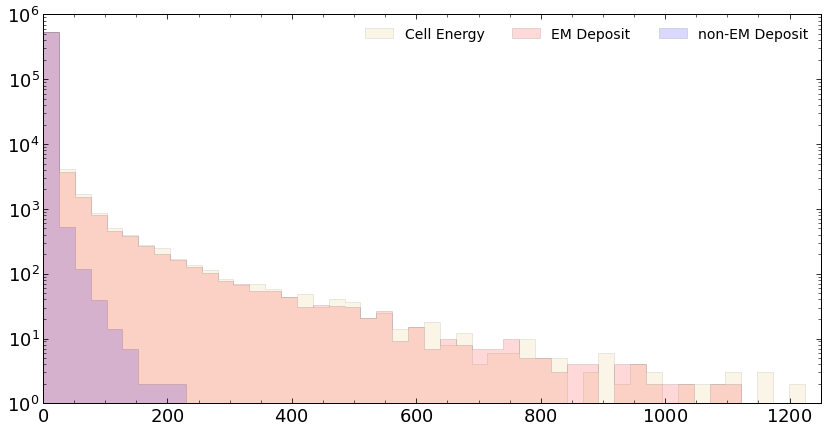

In [24]:
fig = plt.figure(figsize=(12,6))

Bins = np.linspace(0,1250,50,endpoint=True)

ax1 = fig.add_axes([.05,.05,.9,.9])
ax1.hist(Energies, bins=Bins, color='goldenrod', edgecolor='black', alpha=.10, linewidth=.75,
        histtype='stepfilled', label='Cell Energy')
ax1.hist(Energy_EM, bins=Bins, color='red', edgecolor='black', alpha=.15, linewidth=.75,
        histtype='stepfilled', label='EM Deposit')
ax1.hist(Energy_nonEM, bins=Bins, color='blue', edgecolor='black', alpha=.15, linewidth=.75,
        histtype='stepfilled', label='non-EM Deposit')
ax1.set_yscale('log')
ax1.set_xlim(0,1250)
ax1.set_ylim(1,1e6)
ax1.legend(loc='upper right', ncol=3, prop={'size':14})

plt.show()

## Point Normalization

In [4]:
t0 = t.time()
## Normalize rPerp to 1/3630
rPerp_mask = X[:,:,3] != 0
X[:,:,3][rPerp_mask] = X[:,:,3][rPerp_mask]/3630.

## Energy Values that are not zero!
E_nonZeroMask = X[:,:,0] != 0
X[:,:,0][E_nonZeroMask] = np.log(X[:,:,0][E_nonZeroMask])
cellE_mean = np.mean(X[:,:,0][E_nonZeroMask])
cellE_std = np.std(X[:,:,0][E_nonZeroMask])
X[:,:,0][E_nonZeroMask] = (X[:,:,0][E_nonZeroMask] - cellE_mean)/cellE_std

## Eta and Phi
# do nothing for now as a control and check performance
eta_mask = X[:,:,1] != 0
X[:,:,1][eta_mask] = X[:,:,1][eta_mask]/.7

phi_mask = X[:,:,2] != 0
cellPhi_std = np.std(X[:,:,2][phi_mask])
X[:,:,2][phi_mask] = X[:,:,2][phi_mask]/cellPhi_std
t1 = t.time()
print('Time to Normalize: '+str(t1-t0)+' (s)')

Time to Normalize: 0.1260688304901123 (s)
